In [10]:
import sys
sys.path.append('../../build')
sys.path.append('../')
import IPSModule as ips
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import lattpy as lp
import seaborn as sns

from utils import SimulationVisualizer, generate_circle_cluster

Registering LennardJones
Registering Spring


In [13]:
gamma = 1.0
temperature = 0.1
sigma = 1.0
eps = 1.0
r_star = 2.0**(1/6)*sigma
dt = 0.001
n_steps = 100000

In [14]:
particles = ips.LangevinSystem(2, gamma, temperature)
particles.positions = [[r_star, 0.0], [0.0, 0.0]]

In [15]:
# set up the pair force and confinement
pair_force_config = {
    "type": "LennardJones",
    "eps": eps,
    "sigma": sigma
}
confinement_config = {
    "type": "Radial",
    "rad": 100.0
}

In [142]:
simulator = ips.IPS_Simulator_Langevin(particles)
simulator.init(pair_force_config, confinement_config)

In [105]:
np.random.uniform(0, 1, size = (2,2)).tolist()

[[0.8804567188087434, 0.3519824608748614],
 [0.874908696680457, 0.8284197277310483]]

In [143]:
rs = np.zeros(n_steps)
q1s = np.zeros((n_steps, 2))
q2s = np.zeros((n_steps, 2))

for i in range(n_steps):
    q1s[i], q2s[i] = particles.get_positions()
    rs[i] = np.linalg.norm(q1s[i] - q2s[i], 2)
    simulator.integrate(dt)

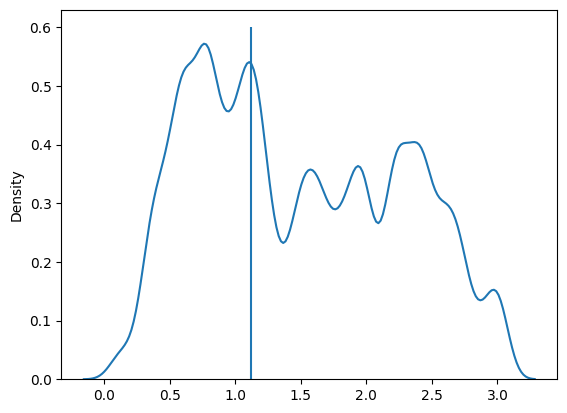

In [151]:
sns.kdeplot(rs)
plt.vlines(x = 2**(1/6), ymin = 0, ymax = 0.6)
plt.show()

In [4]:
def LJ_pot(r, eps, sigma):
    return 4*eps*((sigma/r)**12 - (sigma/r)**6)

def LJ_force(r, eps, sigma):
    return 4*eps*(-12*sigma**12*r**(-13) + 6*sigma**6*r**(-7))

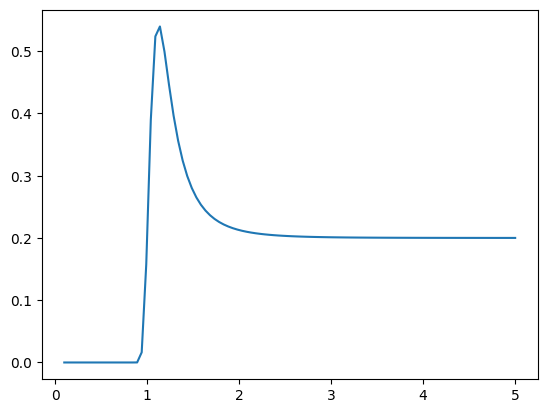

In [11]:
rs_ = np.linspace(0.1, 5, 100)
U = LJ_pot(rs_, eps, sigma)
plt.plot(rs_, 1/5*np.exp(-U))
plt.show()

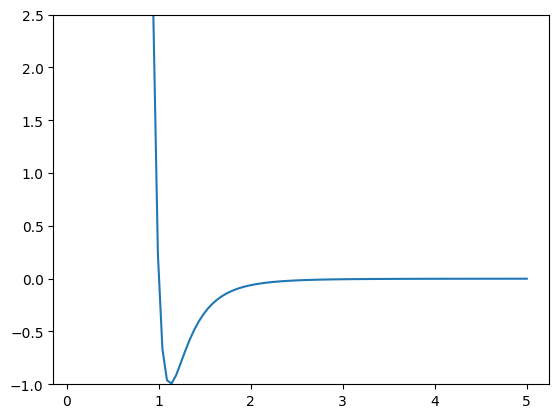

In [8]:
plt.plot(rs_, U)
plt.ylim(-1, 2.5)
plt.show()

# not relying on ergodicity

In [57]:
n_sims = 1000
n_steps = 100000
end_rs = np.zeros(n_sims)
particles = ips.LangevinSystem(2, gamma, temperature)
simulator = ips.IPS_Simulator_Langevin(particles)
simulator.init(pair_force_config, confinement_config)

for i in range(n_sims):
    if i%(n_sims // 20) == 0:
        print(f"{100*i/n_sims:.1f}% complete")
    particles.positions = [[np.random.uniform(0.01, 5), 0.0], [0.0, 0.0]]
    particles.velocities = [[0,0],[0,0]]
    simulator.integrate_n_steps(dt, n_steps)
    end_pos1, end_pos2 = particles.get_positions()
    end_rs[i] = np.linalg.norm(end_pos1 - end_pos2, 2)


0.0% complete
5.0% complete
10.0% complete
15.0% complete
20.0% complete
25.0% complete
30.0% complete
35.0% complete
40.0% complete
45.0% complete
50.0% complete
55.0% complete
60.0% complete
65.0% complete
70.0% complete
75.0% complete
80.0% complete
85.0% complete
90.0% complete
95.0% complete


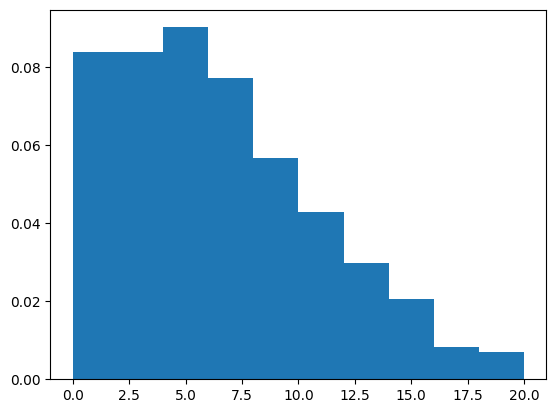

In [ ]:
# can i show this graph at different times? And show that it tends towards the right things?
plt.hist(end_rs, bins = 10, range = (0,20), density=True) # is this closer than it was before? Who knows
plt.show()

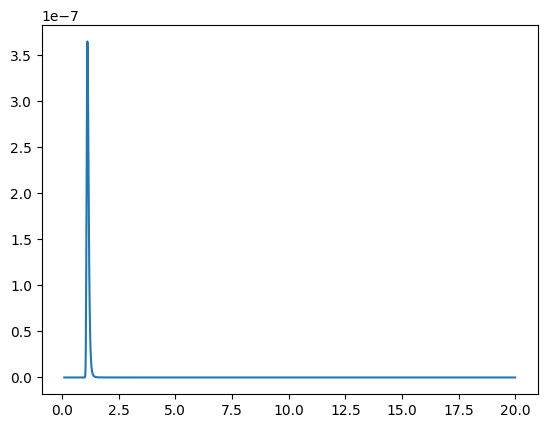

In [56]:
dx = 0.01
rs_ = np.arange(0.1, 20, dx)
U = LJ_pot(rs_, eps, sigma)
beta = 1/temperature
rho = np.exp(-beta*U)
rho /= sum(U*dx)
plt.plot(rs_, rho)
plt.show()

# POT

In [ ]:
import ot
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [97]:
nx_bins = 50
ny_bins = 50

# let's try and get wasserstein dist between two 2d distributions
normal_samples = np.random.multivariate_normal(mean = [0,0], cov=[[1,0],[0,1]], size = 1000000)
normal_samples2 = np.random.multivariate_normal(mean = [0,0], cov=[[1,0],[0,1]], size = 1000000)

random_hist1, xedges, yedges = np.histogram2d(normal_samples[:,0], normal_samples[:,1], bins = (nx_bins, ny_bins), range = ((-2,2), (-2,2)))
random_hist2, xedges, yedges = np.histogram2d(normal_samples2[:,0], normal_samples2[:,1], bins = (nx_bins, ny_bins), range = ((-2,2),(-2,2)))

random_hist1 /= np.sum(random_hist1)
random_hist2 /= np.sum(random_hist1)

random_hist1[random_hist1 == 0] = 1e-16
random_hist2[random_hist2 == 0] = 1e-16


# actual distrib is gaussian
xs = np.linspace(-2, 2, nx_bins)
X, Y = np.meshgrid(xs, xs)
rho = 1/(2*np.pi)*np.exp(-(X**2 + Y**2)/2)
rho /= np.sum(rho)

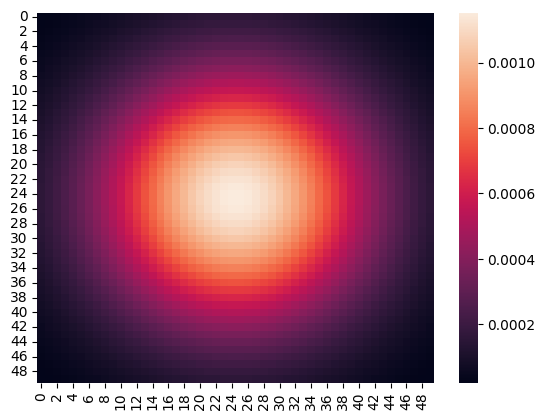

In [98]:
sns.heatmap(rho)
plt.show()

<Axes: >

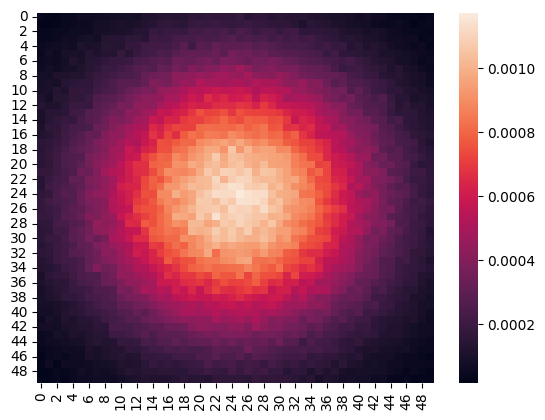

In [99]:
sns.heatmap(random_hist1)

In [ ]:
uni = np.ones((50, 50)) / 2500

In [100]:
sp.stats.entropy(random_hist1.flatten(), rho.flatten())

0.001728790666053805

In [101]:
sp.stats.entropy(uni.flatten(), rho.flatten())

0.3284658730596065

# now the real deal

In [ ]:
eps = 1
sigma = 1
rad = 5

def U_LJ(q1, q2):
    r = np.linalg.norm(q1-q2, 2)
    return 4*eps*((sigma/r)**12 - (sigma/r)**6)


def U_confine(q1, q2):
    u_conf = 0
    
    # loop over each particle
    for q in [q1, q2]:
        # check if particle is in the naughty zone
        if np.linalg.norm(q) >= rad:
            # loop over each dimension
            for i in range(len(q1)):
                u_conf += (-rad-1)*np.log(np.abs(q[i] - rad - 1) - (q[i]**2 + 2*q[i])/2)

    return u_conf

def rho(q1, q2, beta):
    # probby densy
    return np.exp(-beta*U_LJ(q1, q2) + U_confine(q1, q2))

In [106]:
np.array([[1,2], [3,4]]).flatten()

array([1, 2, 3, 4])